<a href="https://colab.research.google.com/github/kozen88/Data_prepro/blob/main/data_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pre-processing of a breast cancer detection dataset


The project consists of various distinct pre-processing pipelines. Each pipeline must contain an appropriate combination of Pipeline and ColumnTransformer objects. The result must be a single final object, whose invocation of the fit_transform method must be reported at the end of the notebook and return the dataset transformed according to the required pre-processing.<br>
<br>


**Each pipeline must be executed on the dataset columns excluding the "target" column.**<br>
<br>

------
------

<br>

## PIPELINE 1:<br>
Set up the preprocessing for only the records with target = 1 according to the following pipeline:

1. Cleaning missing values
2. Symmetrization of only asymmetric variables
3. One-hot encoding of categorical variables
4. Rescaling through standardization

Take into account, in the implementation of this pipeline, the asymmetry of the variables. Cleaning missing values should be differentiated between symmetric and asymmetric variables, using the most appropriate fill value based on the presence or absence of asymmetry.<br>  
<br>
#### Explicit Requests:
- **You have the freedom to choose the most appropriate cleaning method for categorical variables.**

- **To measure the asymmetry of a variable, a graphical analysis supported, if necessary, by a statistical analysis of skewness is recommended.**<br>
<br>
------

<br>

##  PIPELINE 2:<br>
Apply the following pipeline to all records in the dataset:

1. Cleaning missing values using procedures of your choice
2. Discretization into 20 bins for all numerical variables
3. Ordinal encoding for the categorical variable according to values, in ascending order: A, B, C
4. Selection of the 5 most informative variables with respect to the provided target, using the most appropriate metric based on the transformations performed so far.<br>
<br>


------

<br>

## PIPELINE 3:<br>
Apply the following pipeline to all records in the dataset:

1. Cleaning missing values using a method of your choice.
2. Principal Component Analysis to retain 80% of explained variance.
3. Symmetrization.
4. Rescaling through normalization between 0 and 1.<br>
<br>

Exoporting the final pipeline.

In [1]:
# Istalling a library for checking best PCA reduction
!pip install kneed

In [2]:
# lets make the import of what we need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# for studing the asimmetry of distribution
from scipy.stats import skew

# Objects for performing scaling
from sklearn.preprocessing import  MinMaxScaler,  StandardScaler, RobustScaler
# Objects for missing values
from sklearn.impute import SimpleImputer, KNNImputer
# encoder types
from sklearn.preprocessing import  OneHotEncoder, OrdinalEncoder, LabelEncoder
# Objects for Binning and Binarize
from sklearn.preprocessing import KBinsDiscretizer, Binarizer
# Objects to corret asimmetry and apply general function to traform dataset
from sklearn.preprocessing import PowerTransformer, FunctionTransformer

# We retrieve the object that allows us to perform PCA
# and the elbow/knee method
from sklearn.decomposition import PCA
from kneed import KneeLocator

# lets retrieve what is needed for the pipeline building block
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector

# lets retrieve objects and metrics to performe feature selection
from sklearn.feature_selection import SelectKBest, f_regression, r_regression, mutual_info_regression
from sklearn.feature_selection import  f_classif, mutual_info_classif, chi2

# to save and load the pipelines
from joblib import dump, load

## Data exploration
We will load the data to be used and review their main information and characteristics, check for missing values or other issues, and finally, we will analyze the symmetry of the variables to distinguish between variables that are symmetrically distributed from those that are asymmetrically distributed.

In [3]:
df = pd.read_csv("sample_dataset.csv")
df

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,NaN,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,NaN,2019.0,0.16220,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,NaN,NaN,0.0869,0.07017,NaN,0.05667,...,23.41,158.80,1956.0,0.12380,0.1866,0.2416,0.1860,0.2750,NaN,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,NaN,NaN,NaN,0.05999,...,25.53,NaN,1709.0,0.14440,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,NaN,0.2597,0.09744,...,26.50,NaN,567.7,0.20980,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,NaN,NaN,NaN,0.13280,0.1980,NaN,0.1809,NaN,...,16.67,152.20,1575.0,0.13740,NaN,0.4000,0.1625,0.2364,0.07678,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,NaN,0.2439,0.13890,0.1726,0.05623,...,26.40,166.10,2027.0,0.14100,0.2113,0.4107,0.2216,0.2060,0.07115,0
565,NaN,28.25,131.20,1261.0,0.09780,0.10340,0.1440,0.09791,0.1752,NaN,...,38.25,155.00,1731.0,0.11660,0.1922,0.3215,0.1628,0.2572,NaN,0
566,16.60,28.08,108.30,NaN,0.08455,0.10230,NaN,0.05302,0.1590,0.05648,...,34.12,126.70,1124.0,0.11390,NaN,0.3403,0.1418,0.2218,0.07820,0
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.3514,0.15200,0.2397,NaN,...,NaN,184.60,1821.0,0.16500,0.8681,0.9387,0.2650,0.4087,0.12400,0


In [4]:
# Let's see a brief statistical summary for each variable.
result = df.describe().T
result

,count,mean,std,min,25%,50%,75%,max
mean radius,482.0,14.059548,3.501791,6.981000,11.672500,13.280000,15.745000,28.11000
mean texture,492.0,19.311829,4.347769,9.710000,16.170000,18.860000,21.802500,39.28000
mean perimeter,513.0,92.039025,24.028669,43.790000,75.270000,86.340000,104.700000,188.50000
mean area,403.0,661.522581,356.669534,143.500000,428.100000,556.700000,796.000000,2501.00000
mean smoothness,384.0,0.097156,0.014502,0.052630,0.086688,0.096565,0.106825,0.16340
mean compactness,480.0,0.104531,0.053335,0.019380,0.064815,0.093125,0.130325,0.34540
mean concavity,439.0,0.094063,0.083301,0.000000,0.030410,0.068240,0.135100,0.42680
mean concave points,382.0,0.049115,0.038449,0.000000,0.020682,0.033770,0.074122,0.20120
mean symmetry,471.0,0.181405,0.027633,0.106000,0.161950,0.179100,0.196600,0.29060
mean fractal dimension,504.0,0.062626,0.007102,0.049960,0.057530,0.061300,0.066003,0.09744


In [5]:
# lets save the statistics
result.to_csv('describe_result.csv')
result.to_excel('describe_result.xlsx', index=True)

**Reflection:**<br>
From the privious table with the statistics we can observe comparing min a max values found how our variable have different order of magnitude.

**note:** <br>
Lets try to understand what type of variable we have in the dataset in order to decide how to treat them.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              482 non-null    float64
 1   mean texture             492 non-null    float64
 2   mean perimeter           513 non-null    float64
 3   mean area                403 non-null    float64
 4   mean smoothness          384 non-null    float64
 5   mean compactness         480 non-null    float64
 6   mean concavity           439 non-null    float64
 7   mean concave points      382 non-null    float64
 8   mean symmetry            471 non-null    float64
 9   mean fractal dimension   504 non-null    float64
 10  radius error             475 non-null    float64
 11  texture error            434 non-null    float64
 12  perimeter error          381 non-null    float64
 13  area error               494 non-null    object 
 14  smoothness error         4

**Reflection:**<br>
All the variable in our dataset are numeric, in particulart float64 so real number and we have got only one variable area error which is an object tipe, probably a string so it is a categorical variable. The target is numeric, a integer , but is used as a categorical type to show presence or absence.

In [7]:
df['area error'].value_counts()

area error
A    489
B      4
C      1
Name: count, dtype: int64

In [8]:
type(df['area error'][0])

str

**Reflection:**<br>
the type of the variable area error is a string an can assume 3 different values: A, B, C. Definitely a categorical variable.

In [9]:
# Lets check how many missing values we have for each variable
df.isna().sum()

mean radius                 87
mean texture                77
mean perimeter              56
mean area                  166
mean smoothness            185
mean compactness            89
mean concavity             130
mean concave points        187
mean symmetry               98
mean fractal dimension      65
radius error                94
texture error              135
perimeter error            188
area error                  75
smoothness error            77
compactness error          113
concavity error            190
concave points error        62
symmetry error              82
fractal dimension error    157
worst radius                94
worst texture              155
worst perimeter            109
worst area                  57
worst smoothness           101
worst compactness           95
worst concavity             62
worst concave points        74
worst symmetry             159
worst fractal dimension     99
target                       0
dtype: int64

In [10]:
total_missing_values = df.isnull().sum().sum()
print(f"The total number of missing values is {total_missing_values}.")


The total number of missing values is 3318.


In [11]:
# Calculate the percentage of missing values
total_data = df.shape[0] * df.shape[1]
# total_data

ratio_missing = total_missing_values / total_data
# ratio_missing

print(f"The percentual of missing values is the {ratio_missing * 100:.2f}% of all data.")

The percentual of missing values is the 18.81% of all data.


**Reflection:**<br>
The missing values are considerably high in number.

## Asymmetry

### Box Plot
The best chart to highlight the asymmetry of a distribution for a variable is the box plot. This type of chart is particularly effective in showing the symmetry or asymmetry of a distribution, as it clearly displays the position of the median, the quartiles, and any outliers. In particular, box plots are useful in detecting the skewness of a distribution as they visually indicate whether the distribution is symmetric, right-skewed, or left-skewed.<br>
<br>

#### Why Use a Box Plot
Box plots can clearly and intuitively highlight the skewness of a distribution, showing the data distribution through quartiles and the tails of the distribution. Additionally, box plots can identify the presence of outliers that may affect the skewness of the distribution.

Therefore, if you want to effectively visualize the asymmetry of a distribution for a variable, the box plot is the recommended chart as it provides a clear and immediate representation of the distribution's skewness.

-----

### Histogram
The histogram clearly displays the shape of the data distribution, allowing you to identify whether it is symmetric or asymmetric. This is why the histogram is considered an excellent complement to the box plot for asymmetry analysis:

1. The histogram shows the complete data distribution, enabling you to see if the distribution is shifted to the left (negative skewness) or to the right (positive skewness).

2. By comparing the position of the mean and median in the histogram, you can determine the type of skewness. If the mean is greater than the median, there is positive skewness; if the mean is less than the median, there is negative skewness.

3. The shape of the histogram, whether it is more elongated on one side or the other, provides further information on the extent of the asymmetry.<br>

In summary, the histogram is an excellent complement to the box plot for analyzing the symmetry/asymmetry of a distribution, as it allows you to visualize the complete shape of the distribution and quantify the type and extent of the asymmetry..

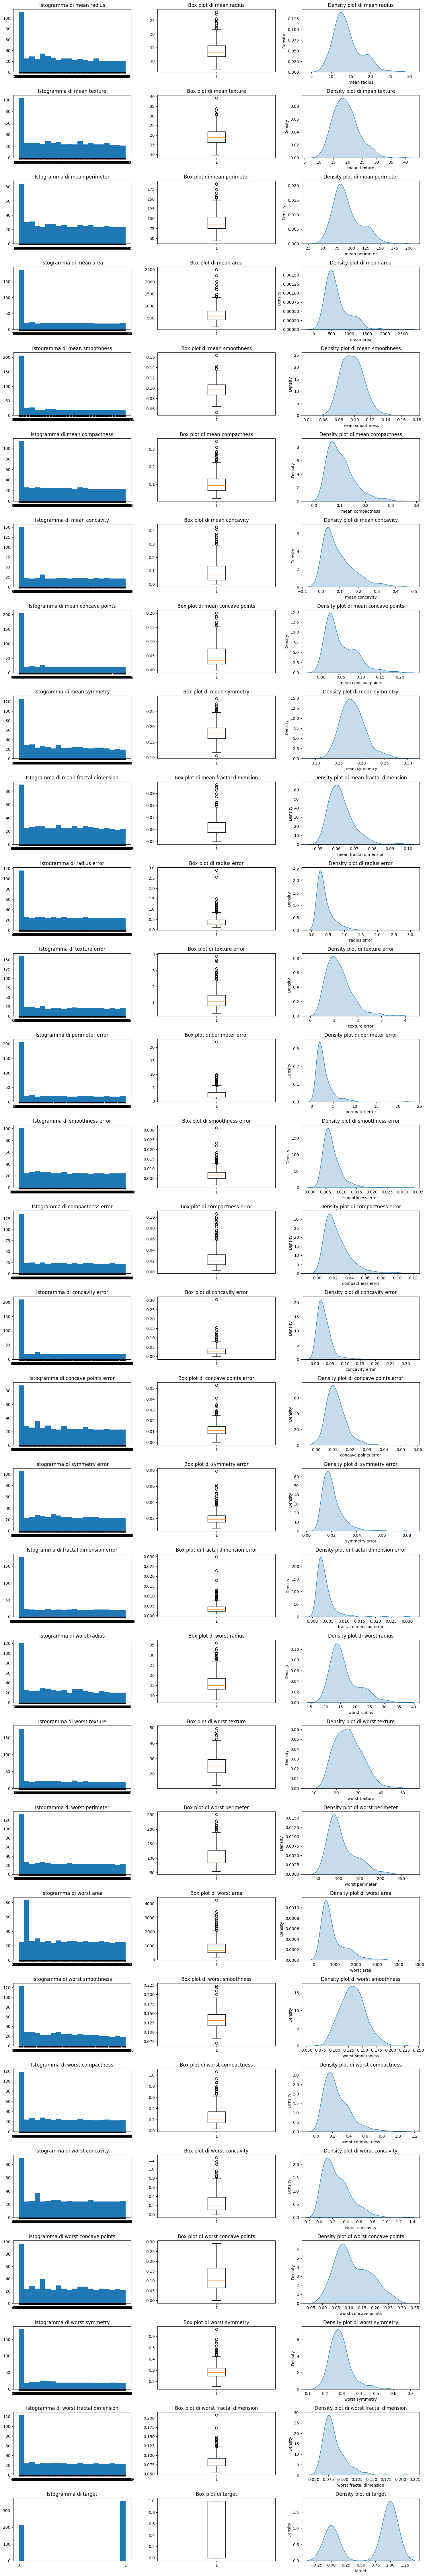

In [12]:
# exclude area error
columns_to_plot = [col for col in df.columns if col != 'area error']

# set the parameter for making a series of 3 plot for each row regarding one variable
# and showing her distribution
fig, axes = plt.subplots(nrows=len(columns_to_plot), ncols=3, figsize=(15, 3*len(columns_to_plot)))

# make the 3 plots for evaluation asimmetry
for i, col in enumerate(columns_to_plot):

    # Histogram
    axes[i, 0].hist(df[col].astype(str), bins=20)
    axes[i, 0].set_title(f"Istogramma di {col}")

    # Box plot
    axes[i, 1].boxplot(df[col].dropna())  # check no missing values
    axes[i, 1].set_title(f"Box plot di {col}")

    # Density plot
    axes[i, 2].set(xlabel=col)
    if df[col].dtype in ['float64', 'int64']:  # check varaible is numeric
        sns.kdeplot(data=df, x=col, ax=axes[i, 2], fill=True)
        axes[i, 2].set_title(f"Density plot di {col}")

plt.tight_layout()
plt.show()

**Reflection:** <br>
From this first study about asimmetry of the distribution, we can see that the magior part of the variables present asimmetry in their distribution, now the point is to quantify it and find a treshold in order to decide which one to rettify and which one not.

### Asimmetry Index
To quantify the asimmetry of the distribution there are different index, in this notebook we will use for didatic purpose 3 of them:

- skewness index
- Yule-Bowley index
- Pearson asimmetry index

more information can be found:
- [asimmetry_resource1](https://paolapozzolo.it/asimmetria-statistica/)
- [asimmetry_resource2](https://www.researchgate.net/publication/38360053_Skewness_and_Asymmetry_Measures_and_Orderings)
- [asimmetry_resource3](https://www.okpedia.it/asimmetria-statistica)

In [13]:
def print_index_asimmetry(list_of_values, index_type):
  """
  This function display the information about the asimmetry associated to each variable.

  Parameters:
  - list_of_values(list of tuple): contain the tuple made as (name_of_variable, asymmetry_value).
  - index_type(str): the index o asimmetry used.
  """
  for e in list_of_values:
      print(f"{index_type} {e[0]} is {e[1]:.3f}.")


In [14]:
skewness_list = []

# calculate skewness index for each variable
for col in [c for c in df.columns if c not in ['area error', 'target']]:
    col_cleaned = df[col].dropna()
    skewness_value = skew(col_cleaned)

    skewness_list.append((col, skewness_value))

print_index_asimmetry(skewness_list, "Index of skewness")

Index of skewness mean radius is 0.925.
Index of skewness mean texture is 0.662.
Index of skewness mean perimeter is 0.903.
Index of skewness mean area is 1.737.
Index of skewness mean smoothness is 0.459.
Index of skewness mean compactness is 1.251.
Index of skewness mean concavity is 1.370.
Index of skewness mean concave points is 1.207.
Index of skewness mean symmetry is 0.631.
Index of skewness mean fractal dimension is 1.369.
Index of skewness radius error is 3.368.
Index of skewness texture error is 1.387.
Index of skewness perimeter error is 3.564.
Index of skewness smoothness error is 2.337.
Index of skewness compactness error is 1.798.
Index of skewness concavity error is 3.908.
Index of skewness concave points error is 1.437.
Index of skewness symmetry error is 2.185.
Index of skewness fractal dimension error is 3.973.
Index of skewness worst radius is 1.125.
Index of skewness worst texture is 0.614.
Index of skewness worst perimeter is 1.161.
Index of skewness worst area is 

In [15]:
yule_bowley_list = []

# Calculate the Yule-Bowley index of asimmetry
for col in [c for c in df.columns if c not in ['area error', 'target']]:
    col_cleaned = df[col].dropna()

    # get quantile
    Q1 = col_cleaned.quantile(0.25)
    Q2 = col_cleaned.median()
    Q3 = col_cleaned.quantile(0.75)
    Yule_Bowley = (Q3 - Q1 - (Q2 - Q1)) / (Q3 - Q1 + (Q2 - Q1))

    yule_bowley_list.append((col, Yule_Bowley))

print_index_asimmetry(yule_bowley_list, "Index of Yule-Bowley")

Index of Yule-Bowley mean radius is 0.434.
Index of Yule-Bowley mean texture is 0.354.
Index of Yule-Bowley mean perimeter is 0.453.
Index of Yule-Bowley mean area is 0.482.
Index of Yule-Bowley mean smoothness is 0.342.
Index of Yule-Bowley mean compactness is 0.397.
Index of Yule-Bowley mean concavity is 0.469.
Index of Yule-Bowley mean concave points is 0.607.
Index of Yule-Bowley mean symmetry is 0.338.
Index of Yule-Bowley mean fractal dimension is 0.384.
Index of Yule-Bowley radius error is 0.471.
Index of Yule-Bowley texture error is 0.411.
Index of Yule-Bowley perimeter error is 0.445.
Index of Yule-Bowley smoothness error is 0.422.
Index of Yule-Bowley compactness error is 0.454.
Index of Yule-Bowley concavity error is 0.396.
Index of Yule-Bowley concave points error is 0.391.
Index of Yule-Bowley symmetry error is 0.393.
Index of Yule-Bowley fractal dimension error is 0.416.
Index of Yule-Bowley worst radius is 0.494.
Index of Yule-Bowley worst texture is 0.327.
Index of Yule

In [16]:
pearson_asimmetry_list = []

# Calculate Pearson asimmetry index
for col in [c for c in df.columns if c not in ['area error', 'target']]:
    col_cleaned = df[col].dropna()

    mean = col_cleaned.mean()
    mode = col_cleaned.mode().iloc[0]
    std = col_cleaned.std()
    pearson_asimmetry = (mean - mode) / std

    pearson_asimmetry_list.append((col, pearson_asimmetry))


print_index_asimmetry(pearson_asimmetry_list, "Index of Pearson asimmetry")

Index of Pearson asimmetry mean radius is 0.491.
Index of Pearson asimmetry mean texture is 1.008.
Index of Pearson asimmetry mean perimeter is -1.775.
Index of Pearson asimmetry mean area is 0.953.
Index of Pearson asimmetry mean smoothness is -0.244.
Index of Pearson asimmetry mean compactness is -0.191.
Index of Pearson asimmetry mean concavity is 1.129.
Index of Pearson asimmetry mean concave points is 1.277.
Index of Pearson asimmetry mean symmetry is 0.351.
Index of Pearson asimmetry mean fractal dimension is 0.839.
Index of Pearson asimmetry radius error is 0.419.
Index of Pearson asimmetry texture error is 0.646.
Index of Pearson asimmetry perimeter error is 0.530.
Index of Pearson asimmetry smoothness error is 0.655.
Index of Pearson asimmetry compactness error is 0.117.
Index of Pearson asimmetry concavity error is 1.173.
Index of Pearson asimmetry concave points error is 1.941.
Index of Pearson asimmetry symmetry error is 0.869.
Index of Pearson asimmetry fractal dimension e

**note**:<br>
To categorize the variable as simmetric or asimmetric we will use the Pearson asimmetry index, feel free to use another between the three index used. **PAY ATTENTION!** we will consider as asimmetric only the variable that present an absoloute Pearson index above 0.3 and for those we will procede to correct the asimmetry with a power trasformation.

In [17]:
def get_asimmetric_variables(list_of_variables, asimmetry_treshold):
  """
  This function get a list of string which are tthe name of the variables that are considered asimmetric
  based on the treshold, the asimmetry valueted is the Pearson asimmetry index.

  Parameters:
  - list_of_variables(list of tuple): the tuple are made as follow (name_of_variable, asimmetry_value).
  - asimmetry_treshold(float): the number that set the treshold for the asimmetry to be considerate as moderate or high.

  Return:
  -  asimmetric_variable_list(list of str): is a list which contain the string representing the name of the variables that are considered asimmetric.
  """

  asimmetric_variable_list = []

  # check on the treshold range
  if asimmetry_treshold < 0 or asimmetry_treshold > 1:
    pass
  else:
    for e in list_of_variables:
      if abs(e[1]) > asimmetry_treshold: # consider the module of the asimmetry value
        asimmetric_variable_list.append(e[0]) # and if major then the treshold add the variable to the list

  return asimmetric_variable_list

In [18]:
# select the asimmetric variables
treshold_for_pearson_asimmetry = 0.3

asimmetric_variables = get_asimmetric_variables(pearson_asimmetry_list, treshold_for_pearson_asimmetry)
print(f"The variables considered asimmetric are {len(asimmetric_variables)} on the total of {len(pearson_asimmetry_list)}, and they are:\n")
for v in asimmetric_variables:
  print(f"-> {v}")


The variables considered asimmetric are 26 on the total of 29, and they are:

-> mean radius
-> mean texture
-> mean perimeter
-> mean area
-> mean concavity
-> mean concave points
-> mean symmetry
-> mean fractal dimension
-> radius error
-> texture error
-> perimeter error
-> smoothness error
-> concavity error
-> concave points error
-> symmetry error
-> fractal dimension error
-> worst radius
-> worst texture
-> worst perimeter
-> worst area
-> worst smoothness
-> worst compactness
-> worst concavity
-> worst concave points
-> worst symmetry
-> worst fractal dimension


**Reflection:**<br>
As already forseen from the plots the maggiority of the variables are asimmetric.

### Implementing the PIPELINE 1:<br>
Set up the preprocessing for only the records with target = 1 according to the following pipeline:

1. Cleaning missing values
2. Symmetrization of only asymmetric variables
3. One-hot encoding of categorical variables
4. Rescaling through standardization

Take into account, in the implementation of this pipeline, the asymmetry of the variables. Cleaning missing values should be differentiated between symmetric and asymmetric variables, using the most appropriate fill value based on the presence or absence of asymmetry.<br>  
<br>
#### Explicit Requests:
- **You have the freedom to choose the most appropriate cleaning method for categorical variables.**

- **To measure the asymmetry of a variable, a graphical analysis supported, if necessary, by a statistical analysis of skewness is recommended.**<br>
<br>

In [19]:
# implementing the  subpipelines for making the pipeline1

# for variables numerical asimmetric
pipeline_1_numeric_asimmetric = Pipeline([
    ('imputer_asimmetric', SimpleImputer(strategy='median')), # used median because robust to outlier and asimmetry
    ('power_transform', PowerTransformer()),
    ('standardize', StandardScaler())
])

# for variables numerical simmetric
pipeline_1_numeric_simmetric = Pipeline([
    ('imputer_simmetric', SimpleImputer(strategy='mean')),
    ('standardize', StandardScaler())
])

# for variables categorical
pipeline_1_categorical = Pipeline([
    ('imputer_categorical', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(sparse=False))
])

In [20]:
simmetric_variables = list(set(df.columns) - set(asimmetric_variables) - {'target', 'area error'})
simmetric_variables

['compactness error', 'mean smoothness', 'mean compactness']

In [21]:
# Using a ColumnTrasformer to unify the 3 subpipilens created priviuosly:
# pipeline_1_numeric_asimmetric
# pipeline_1_numeric_simmetric
# pipeline_1_categorical
transformer_pipe1 = ColumnTransformer([
    ('categorical_prepro_1', pipeline_1_categorical, make_column_selector(dtype_include=['object'])),
    ('numeric_simmetric_prepro_1', pipeline_1_numeric_simmetric, make_column_selector(pattern='|'.join(simmetric_variables))),
    ('numeric_asimmetric_prepro_1', pipeline_1_numeric_asimmetric, make_column_selector(pattern='|'.join(asimmetric_variables)))
])

# creation of final pipeline
pipeline_1 = Pipeline([
    ('preprocessing_pipe_1', transformer_pipe1)
])

pipeline_1

Pipeline(steps=[('preprocessing_pipe_1',
                 ColumnTransformer(transformers=[('categorical_prepro_1',
                                                  Pipeline(steps=[('imputer_categorical',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7c8e3d05d690>),
                                                 ('numeric_simmetric_prepro_1',
                                                  Pipeline(steps=[('imp...
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7c8e3d05fbb0>),
                                                 ('numeric_asimmetric_prepro_1',
                                                  Pipeline(steps=[('imputer_asimmetric',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('power_transform',
                                                                   PowerTransformer()),
                                                                  ('standardize',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7c8e3d05fb80>)]))])

In [22]:
# Apply the pipeline 1 only to the record with target = 1
X_target_1 = df.loc[df['target'] == 1, :].copy()
X_target_1_preprocessed = pipeline_1.fit_transform(X_target_1)

# Leave the other record without preprocessing
X_target_other = df.loc[df['target'] != 1, :].copy()
X_target_other_preprocessed = X_target_other


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [23]:
# save the pepiline_1 into a specific file for future use
dump(pipeline_1, 'pipeline_1.joblib')

['pipeline_1.joblib']

### Implementing PIPELINE 2:<br>
Apply the following pipeline to all records in the dataset:

1. Cleaning missing values using procedures of your choice
2. Discretization into 20 bins for all numerical variables
3. Ordinal encoding for the categorical variable according to values, in ascending order: A, B, C
4. Selection of the 5 most informative variables with respect to the provided target, using the most appropriate metric based on the transformations performed so far.<br>
<br>



In [24]:
# for numeric variables subpipeline preprocessing
pipeline_2_numeric = Pipeline([
    ('imputer_numeric', SimpleImputer(strategy='median')),
    ('binning_20', KBinsDiscretizer(strategy='quantile', n_bins=20, encode='ordinal'))
])

# for categorical variables subpipeline preprocessing
pipeline_2_categorical = Pipeline([
    ('imputer_categorical', SimpleImputer(strategy='most_frequent')),
    ('ordinal_encoding', OrdinalEncoder(categories=[["A","B","C"]]))
])

In [25]:
# using a ColumnTrasformere to unify the privious subpipeline:
# pipeline_2_numeric
# pipeline_2_categorical
transformer_pipe2 = ColumnTransformer([
    ('categorical_prepro_2', pipeline_2_categorical, make_column_selector(dtype_include=['object'])),
    ('numeric_prepro_2', pipeline_2_numeric, make_column_selector(dtype_exclude=['object'])),
])

# for feature selection we adopt aproach variable numeric target numeric categoric
feature_selector = SelectKBest(chi2, k = 5)

# Creation of the final pipeline ending with future selection
pipeline_2 = Pipeline([
    ('preprocessing_pipe_2', transformer_pipe2),
    ('feature_selection', feature_selector)
])

pipeline_2

Pipeline(steps=[('preprocessing_pipe_2',
                 ColumnTransformer(transformers=[('categorical_prepro_2',
                                                  Pipeline(steps=[('imputer_categorical',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinal_encoding',
                                                                   OrdinalEncoder(categories=[['A',
                                                                                               'B',
                                                                                               'C']]))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7c8e37036860>),
                                                 ('numeric_prepro_2',
                                                  Pipeline(steps=[('imputer_numeric',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('binning_20',
                                                                   KBinsDiscretizer(encode='ordinal',
                                                                                    n_bins=20))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7c8e37034190>)])),
                ('feature_selection',
                 SelectKBest(k=5,
                             score_func=<function chi2 at 0x7c8e3ddfe290>))])

In [26]:
# preparing input and target
X = df.drop('target', axis=1)
y = df['target']

In [27]:
# configuration of the pipeline_2
pipeline_2.fit(X,y)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 3 are removed. Consider decreasing the number of bins.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 4 are removed. Consider decreasing the number of bins.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_discretization.py:279

Pipeline(steps=[('preprocessing_pipe_2',
                 ColumnTransformer(transformers=[('categorical_prepro_2',
                                                  Pipeline(steps=[('imputer_categorical',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinal_encoding',
                                                                   OrdinalEncoder(categories=[['A',
                                                                                               'B',
                                                                                               'C']]))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7c8e37036860>),
                                                 ('numeric_prepro_2',
                                                  Pipeline(steps=[('imputer_numeric',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('binning_20',
                                                                   KBinsDiscretizer(encode='ordinal',
                                                                                    n_bins=20))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7c8e37034190>)])),
                ('feature_selection',
                 SelectKBest(k=5,
                             score_func=<function chi2 at 0x7c8e3ddfe290>))])

In [28]:
# application of the pipeline_2
pipeline_2.transform(X)

array([[17., 17.,  9., 19., 17.],
       [18., 16., 16., 18., 14.],
       [18., 16.,  9., 18., 17.],
       ...,
       [15., 13., 13., 15., 11.],
       [19., 17., 17., 18., 17.],
       [ 0.,  0.,  0., 10.,  0.]])

In [29]:
# save the pipeline_2 into a specific file for future use
dump(pipeline_2, 'pipeline_2.joblib')

['pipeline_2.joblib']

### Implementing PIPELINE 3:<br>
Apply the following pipeline to all records in the dataset:

1. Cleaning missing values using a method of your choice.
2. Principal Component Analysis to retain 80% of explained variance.
3. Symmetrization.
4. Rescaling through normalization between 0 and 1.<br>
<br>


**note**:<br>
the symmetrization is not spefied on wich variables and is reported as aoperation to perform after the PCA so we don't know the new variables, so this time beacuse all variable may suffer asimmetry in different way we will use a Power Trasformation on all of them.

In [30]:
# removing the categorical variable
X_no_categorical = X.drop('area error', axis=1)

In [32]:
# creating the pipeline with the requested step
pipeline_3 = Pipeline([
    ('imputer_numeric', SimpleImputer(strategy='median')),
    ('standardize', StandardScaler()),
    ('pca_reduction', PCA(n_components=0.8)),
    ('symmetrization', PowerTransformer()),
    ('min_max_normalization', MinMaxScaler())
])

pipeline_3

Pipeline(steps=[('imputer_numeric', SimpleImputer(strategy='median')),
                ('standardize', StandardScaler()),
                ('pca_reduction', PCA(n_components=0.8)),
                ('symmetrization', PowerTransformer()),
                ('min_max_normalization', MinMaxScaler())])

In [33]:
# configuration of the pipeline_3
pipeline_3.fit(X_no_categorical, y)

Pipeline(steps=[('imputer_numeric', SimpleImputer(strategy='median')),
                ('standardize', StandardScaler()),
                ('pca_reduction', PCA(n_components=0.8)),
                ('symmetrization', PowerTransformer()),
                ('min_max_normalization', MinMaxScaler())])

In the previous cell a get an error on the convertion for type A, because there is not an encoding for categoorical values in this pipeline. I'am bit confused on how to work with the tree pipelines required.

In [34]:
# application of pipeline_3
pipeline_3.transform(X_no_categorical)

array([[ 8.83910242e-01,  6.50877977e-01,  3.69995319e-01, ...,
         3.14555838e-01,  6.79557318e-01,  5.10755611e-01],
       [ 6.92320401e-01,  2.46965884e-01,  5.09382730e-01, ...,
         3.92431226e-01,  4.85674512e-01,  5.44211609e-01],
       [ 7.58960145e-01,  4.42196557e-01,  4.84157442e-01, ...,
         3.82124716e-01,  5.30966664e-01,  4.18618375e-01],
       ...,
       [ 6.13957740e-01,  3.70750132e-01,  5.77681985e-01, ...,
         4.38555204e-01,  4.90016669e-01,  4.75620184e-01],
       [ 9.31285602e-01,  5.38652680e-01,  2.86237050e-01, ...,
         3.49936820e-01,  4.35354311e-01,  6.74860113e-01],
       [-6.66133815e-16,  5.01996765e-01,  5.83997256e-01, ...,
         2.18582142e-01,  6.03155362e-01,  4.07109414e-01]])

In [36]:
# save the pipeli_3 into a specific file for future use.
dump(pipeline_3, 'pipeline_3.joblib')

['pipeline_3.joblib']